In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [13]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
len(dataset)

68

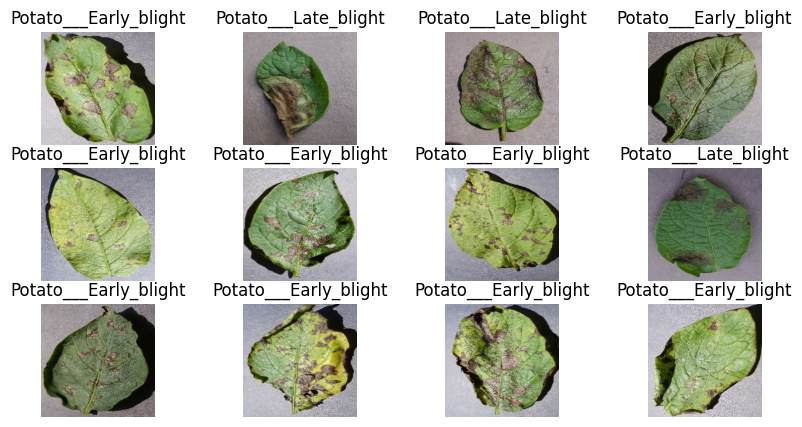

In [17]:
plt.figure(figsize=(10,5))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [19]:
len(dataset)

68

In [21]:
#80% ==> training
#20 ==> 10% validation, 10% test

In [23]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [25]:
train_ds = dataset.take(54)
len(train_ds)

54

In [27]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [29]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [31]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [33]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [39]:
len(train_ds)

54

In [41]:
len(val_ds)

6

In [43]:
len(test_ds)

8

In [45]:
#Optimizamos con prefetch para que la CPU y GPU trabajen simultáneamente

In [47]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
#Con la siguiente capa, eliminamos restricciones para futuras imagenes con diferente tamaño
#de manera que si no son 256x256 las redimensionara y reescalará.

In [53]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [55]:
#DATA AUGMENTATION. Cogeremos la misma imagen y crearemos cuatro más con diferentes filtros
#1 con zoon, 1 con contraste, 1 con rotación, 1 ampliada, para detectar diferentes features en ellas

In [59]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [63]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
#Arquitectura de modelo: CNN coupled con activación softmax en la output layer
#Además reescalamiento, normalización y data augmentation

In [71]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape = input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [75]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.4931 - loss: 0.9065 - val_accuracy: 0.5990 - val_loss: 0.8718
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.7049 - loss: 0.6591 - val_accuracy: 0.8333 - val_loss: 0.5278
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.8825 - loss: 0.2953 - val_accuracy: 0.6510 - val_loss: 1.5881
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.8779 - loss: 0.3439 - val_accuracy: 0.7865 - val_loss: 0.6412
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.9323 - loss: 0.1886 - val_accuracy: 0.7604 - val_loss: 0.8483
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - accuracy: 0.9369 - loss: 0.1890 - val_accuracy: 0.8021 - val_loss: 0.8315
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.9497 - loss: 0.1469 - val_accuracy: 0.9375 - val_loss: 0.1695
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - accuracy: 0.9670 - loss: 0.0957 - val_accu

In [77]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9609 - loss: 0.1680


In [79]:
scores

[0.16797225177288055, 0.9609375]

In [81]:
history

In [83]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [85]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [87]:
history.history['accuracy']

[0.4930555522441864,
 0.7048611044883728,
 0.8825231194496155,
 0.8778935074806213,
 0.9322916865348816,
 0.9369212985038757,
 0.9496527910232544,
 0.9670138955116272,
 0.9623842835426331,
 0.9548611044883728,
 0.9612268805503845,
 0.9728009104728699,
 0.9756944179534912,
 0.9421296119689941,
 0.9693287014961243,
 0.9797453880310059,
 0.9733796119689941,
 0.9733796119689941,
 0.9722222089767456,
 0.9623842835426331,
 0.9728009104728699,
 0.9895833134651184,
 0.9872685074806213,
 0.9756944179534912,
 0.9884259104728699,
 0.9895833134651184,
 0.9803240895271301,
 0.9890046119689941,
 0.9774305820465088,
 0.9924768805503845,
 0.9953703880310059,
 0.9496527910232544,
 0.9809027910232544,
 0.9890046119689941,
 0.9820601940155029,
 0.9837962985038757,
 0.9872685074806213,
 0.9890046119689941,
 0.9837962985038757,
 0.9936342835426331,
 0.9953703880310059,
 0.9936342835426331,
 0.9855324029922485,
 0.9855324029922485,
 0.9890046119689941,
 0.9884259104728699,
 0.9953703880310059,
 0.9872685074

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

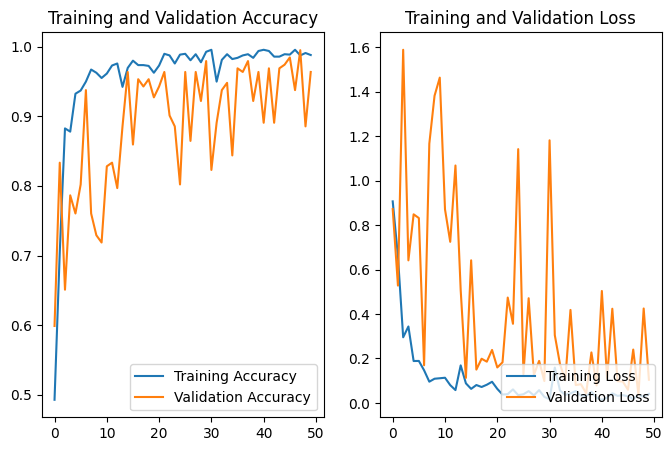

In [91]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First image to predict
First image's actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted label: Potato___Late_blight


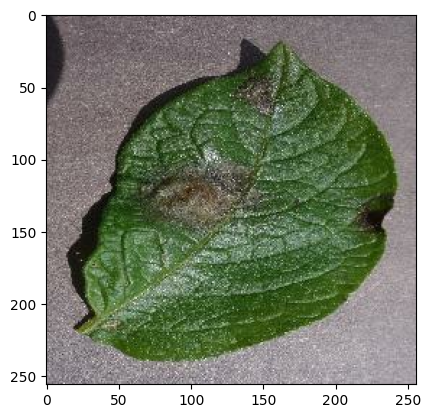

In [93]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


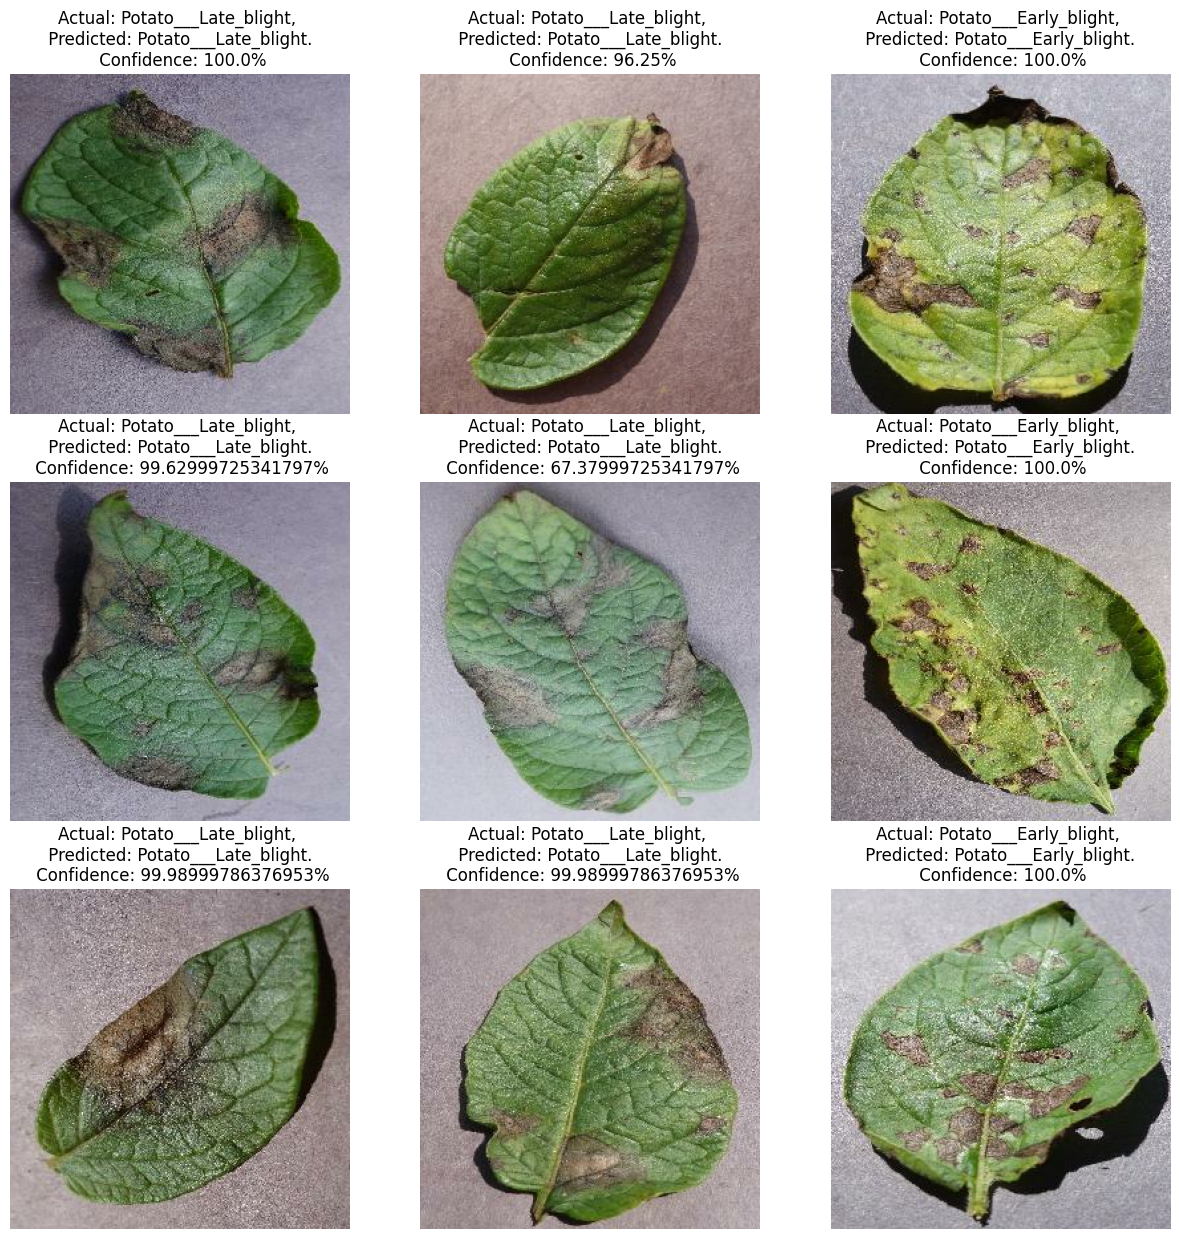

In [97]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")

In [103]:
model.save("../models/potatoes.keras")